In [7]:
import numpy as np
import regression as reg
from scipy import io
from auxiliary_merge import m_DateList
import os, sys
from bma_merge import bma
from auxiliary_merge import extrapolation


# read from inputs
# time1 = int(sys.argv[1])
# time2 = int(sys.argv[2])
# print(time1,time2)

prefix = ['ERA5_', 'MERRA2_', 'JRA55_']

### Local Mac settings
# input files/paths
gmet_stnfile = '/Users/localuser/Research/EMDNA/basicinfo/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'
file_mask = './DEM/NA_DEM_010deg_trim.mat'
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
path_readowngrid = ['/Users/localuser/Research/EMDNA/downscale/ERA5',  # downscaled gridded data
                    '/Users/localuser/Research/EMDNA/downscale/MERRA2',
                    '/Users/localuser/Research/EMDNA/downscale/JRA55']
file_readownstn = ['/Users/localuser/Research/EMDNA/downscale/ERA5_downto_stn_nearest.npz', # downscaled to stn points
                   '/Users/localuser/Research/EMDNA/downscale/MERRA2_downto_stn_nearest.npz',
                   '/Users/localuser/Research/EMDNA/downscale/JRA55_downto_stn_nearest.npz']

# output files/paths (can also be used as inputs once generated)
near_path = '/Users/localuser/Research/EMDNA/correction'  # path to save near station for each grid/cell
path_ecdf = '/Users/localuser/Research/EMDNA/merge/ECDF'
path_pop = '/Users/localuser/Research/EMDNA/pop'
### Local Mac settings


# ### Plato settings
# gmet_stnfile = '/datastore/GLOBALWATER/CommonData/EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
# path_readowngrid = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds',  # downscaled gridded data
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds']
# file_readownstn = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds/ERA5_downto_stn_GWR.npz', # downscaled to stn points
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/MERRA2_downto_stn_GWR.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds/JRA55_downto_stn_GWR.npz']
# near_path = '/home/gut428/ReanalysisCorrMerge'  # path to save near station for each grid/cell
# path_ecdf = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/ECDF'
# path_pop = '/home/gut428/ReanalysisCorrMerge/pop'
# file_popmerge_stn = '/home/gut428/ReanalysisCorrMerge/pop/bmamerge_pop_stn.npz'
# ### Plato settings

near_stnfile = near_path + '/near_stn_prcp.npz'
near_gridfile = near_path + '/near_grid_prcp.npz'
file_reapop_stn = path_pop + '/reanalysis_pop_stn.npz'
file_popmerge_stn = path_pop + 'bmamerge_pop_stn.npz'


In [156]:
########################################################################################################################

# basic processing
print('start basic processing')

lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels

# meshed lat/lon of the target region
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date list
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp['prcp_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

# load near station information
datatemp = np.load(near_file_GMET)
near_loc_stn = datatemp['near_stn_prcpLoc']
near_weight_stn = datatemp['near_stn_prcpWeight']
near_dist_stn = datatemp['near_stn_prcpDist']
near_loc_grid = datatemp['near_grid_prcpLoc']
near_weight_grid = datatemp['near_grid_prcpWeight']
near_dist_grid = datatemp['near_grid_prcpDist']
near_loc_grid = np.flipud(near_loc_grid)
near_weight_grid = np.flipud(near_weight_grid)
near_dist_grid = np.flipud(near_dist_grid)

# probability bins for QM
binprob = 500
ecdf_prob = np.arange(0, 1 + 1 / binprob, 1 / binprob)

########################################################################################################################

# load downscaled reanalysis at station points
print('load downscaled reanalysis data at station points')
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr['prcp_readown']
    readata_stn[rr, :, :] = temp
    del dr, temp
readata_stn[readata_stn < 0] = 0


start basic processing
load downscaled reanalysis data at station points


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


In [167]:
yearin=2018
monthin=2
for y in range(yearin, yearin + 1):
    for m in range(monthin-1, monthin):
        print('year,month',y,m+1)
        file_reapop = path_pop + '/rea_pop_' + str(y * 100 + m + 1) + '.npz'
        file_bmapop = path_pop + '/bmamerge_pop_' + str(y * 100 + m + 1) + '.npz'
        if os.path.isfile(file_bmapop):
            print('file exists ... continue')
            continue

        # date processing
        indmy = (date_number['yyyy'] == y) & (date_number['mm'] == m + 1)
        mmdays = np.sum(indmy)

        # read raw gridded reanalysis data
        readata_raw = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)
        for rr in range(reanum):
            if not (prefix[rr] == 'MERRA2_' and y == 1979):
                filer = path_readowngrid[rr] + '/' + prefix[rr] + 'ds_prcp_' + str(y*100 +m+1) + '.npz'
                d = np.load(filer)
                readata_raw[rr, :, :, :] = d['data']
                del d

        ################################################################################################################
        print('estimate pop for all grids')
        reapop_grid = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)
        if os.path.isfile(file_reapop):
            datatemp = np.load(file_reapop)
            reapop_grid = datatemp['reapop_grid']
            del datatemp
        else:
            for r in range(nrows):
                if np.mod(r,10)==0:
                    print(r, nrows)
                for c in range(ncols):
                    if np.isnan(mask[r, c]):
                        continue
                    nearloc = near_loc_grid[r, c, :]
                    neardist = near_dist_grid[r, c, :]
                    nearweight = near_weight_grid[r, c, :]
                    neardist = neardist[nearloc > -1]
                    nearweight = nearweight[nearloc > -1]
                    nearweight = nearweight / np.sum(nearweight)
                    nearloc = nearloc[nearloc > -1]

                    nstn_prcp = len(nearloc)
                    w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
                    for i in range(nstn_prcp):
                        w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

                    x_red = np.ones([nstn_prcp, 2])
                    for rr in range(1):
                        for tt in range(1):
                            prea_tar = readata_raw[rr, r, c, tt]
                            prea_near = readata_stn[rr, nearloc, tt]
                            pstn_near = stndata[nearloc, tt]
                            pstn_near[pstn_near > 0] = 1

                            # logistic regression
                            if np.all(pstn_near == 1):
                                reapop_grid[rr, r, c, tt] = 1
                            elif np.all(pstn_near == 0) or np.all(prea_near < 0.01):
                                reapop_grid[rr, r, c, tt] = 0
                            else:
                                x_red[:, 1] = prea_near
                                model = LogisticRegression(solver='lbfgs')
                                model.fit(np.reshape(prea_near, [-1, 1]), pstn_near, sample_weight=nearweight)
                                reapop_grid[rr, r, c, tt] = model.predict_proba(np.reshape(prea_tar, [-1, 1]))[0][1]
#                                 tx_red = np.transpose(x_red)
#                                 twx_red = np.matmul(tx_red, w_pcp_red)
#                                 b = reg.logistic_regression(x_red, twx_red, pstn_near)
#                                 if np.all(b == 0) or np.any(np.isnan(b)):
#                                     reapop_grid[rr, r, c, tt] = np.dot(nearweight, pstn_near)
#                                 else:
#                                     zb = - np.dot(np.array([1, prea_tar]), b)
#                                     reapop_grid[rr, r, c, tt] = 1 / (1 + np.exp(zb))

year,month 2018 2
estimate pop for all grids
0 800
10 800
20 800
30 800
40 800


KeyboardInterrupt: 

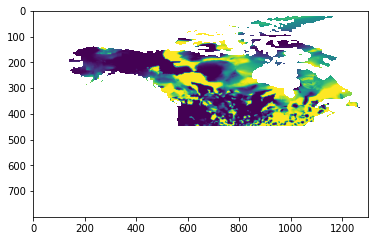

In [145]:
zz=reapop_grid[0,:,:,0].copy()
plt.imshow(zz)

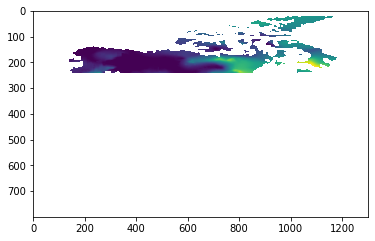

In [158]:
zz2=reapop_grid[0,:,:,0].copy()
plt.imshow(zz2)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until


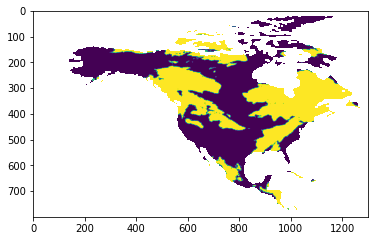

In [185]:
pz=readata_raw[0,:,:,0].copy()
pz[pz>0.3]=1
pz[pz<=0.3]=0
plt.imshow(pz)
plt.clim([0,1])

In [160]:
zz[200,580]

1.0

In [161]:
zz2[200,580]

0.099420115

In [114]:
reapop_grid[0,66,966,0]

nan

In [175]:
            for r in range(200,201):
                if np.mod(r,10)==0:
                    print(r, nrows)
                for c in range(580,581):
                    if np.isnan(mask[r, c]):
                        continue
                    nearloc = near_loc_grid[r, c, :]
                    neardist = near_dist_grid[r, c, :]
                    nearweight = near_weight_grid[r, c, :]
                    neardist = neardist[nearloc > -1]
                    nearweight = nearweight[nearloc > -1]
                    nearweight = nearweight / np.sum(nearweight)
                    nearloc = nearloc[nearloc > -1]

                    nstn_prcp = len(nearloc)
                    w_pcp_red = np.zeros([nstn_prcp, nstn_prcp])
                    for i in range(nstn_prcp):
                        w_pcp_red[i, i] = nearweight[i]  # eye matrix: stn weight in one-one lien

                    x_red = np.ones([nstn_prcp, 2])
                    for rr in range(1):
                        for tt in range(1):
                            prea_tar = readata_raw[rr, r, c, tt]
                            prea_near = readata_stn[rr, nearloc, tt]
                            pstn_near = stndata[nearloc, tt]
                            pstn_near[pstn_near > 0] = 1

                            # logistic regression
                            if np.all(pstn_near == 1):
                                reapop_grid[rr, r, c, tt] = 1
                            elif np.all(pstn_near == 0) or np.all(prea_near < 0.01):
                                reapop_grid[rr, r, c, tt] = 0
                            else:
                                x_red[:, 1] = prea_near
                                tx_red = np.transpose(x_red)
                                twx_red = np.matmul(tx_red, w_pcp_red)
                                b = reg.logistic_regression(x_red, twx_red, pstn_near)
                                if np.all(b == 0) or np.any(np.isnan(b)):
                                    reapop_grid[rr, r, c, tt] = np.dot(nearweight, pstn_near)
                                else:
                                    zb = - np.dot(np.array([1, prea_tar]), b)
                                    reapop_grid[rr, r, c, tt] = 1 / (1 + np.exp(zb))

200 800


In [180]:
print(prea_near)
print(pstn_near)
print(prea_tar)

[0.00192018 0.         0.00144014 0.         0.         0.
 0.0062406  0.         0.         0.         0.00768074 0.00768074
 0.00768074 0.00768074 0.0115211  0.00048005 0.         0.02928281
 0.         0.00240023]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.23225883


In [181]:
reapop_grid[rr, r, c, tt]

1.0

In [191]:
                                model = LogisticRegression(solver='saga')
                                model.fit(np.reshape(prea_near, [-1, 1]), pstn_near, sample_weight=nearweight)
                                model.predict_proba(np.reshape(prea_tar, [-1, 1]))[0][1]

0.100069836

In [132]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
import os
import sys

########################################################################################################################
# date_cal_start = int(sys.argv[1]) # yyyymmdd
# date_cal_end = int(sys.argv[2])

# 0. read/define configuration information

# setting: start and end date
# calculation start/end date:
date_cal_start = 19790101  # yyyymmdd: start date
date_cal_end = 19790131  # yyyymmdd: end date
# station data (in PathStn) start/end date:
date_stn_start = 19790101  # yyyymmdd: start date
date_stn_end = 20181231  # yyyymmdd: end date

# setting: paramters for lag correlation of tmean_stn_daily, and cross-correlation between prcp and trange_stn_daily
windows = 1  # parameters for auto-cc t-p-cc calculation: 1 could be better than 31
lag = 1

# setting: searching nearby stations
nearstn_min = 20  # nearby stations: minimum number
nearstn_max = 30  # nearby stations: maximum number
search_radius = 400  # km. only search stations within this radius even nearstn_max cannot be reached
max_dist = 100  # max_distance in distance-based weight calculation

# setting: parameters for transforming temp to approximate normal distribution
trans_mode = 'none'  # box-cox or power-law or none
trans_exp_daily = 4

# setting: overwrite flags. -1:don't save files; 0: don't overwrite files; 1 is to overwrite existing files;
ow_daily = 0
ow_weight = 0
ow_stn = 0

# setting: output files
datestr = str(date_cal_start) + '-' + str(date_cal_end)

### Plato settings
# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'  # station basic information (lists)
# FileGridInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/gridinfo_whole.nc'  # study area information
# PathStn = '/home/gut428/GMET/StnInput_daily'

# FileStnData = '/home/gut428/GMET/PyGMETout/stndata_' + datestr + '.npz'
# FileWeight = '/home/gut428/GMET/PyGMETout/weight.npz'
# FileRegError_daily = '/home/gut428/GMET/PyGMETout/error_' + datestr + '.npz'  # regression error at station points
# FileRegError_daily_corr = '/home/gut428/GMET/PyGMETout/error_rescorr' + datestr + '.npz'  # regression error after residual correction
# FileRegression_daily = '/home/gut428/GMET/PyGMETout/output_' + datestr + '.npz'
### Plato settings

### Mac settings
FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'  # station basic information (lists)
FileGridInfo = '/Users/localuser/GMET/pyGMET_NA/gridinfo_whole.nc'  # study area information
PathStn = '/Users/localuser/GMET/StnInput_daily'

FileStnData = '/Users/localuser/Research/EMDNA/regression/stndata_' + datestr + '.npz'
FileWeight = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz'
FileRegError_daily = '/Users/localuser/Research/EMDNA/regression/error_notrans_' + datestr + '.npz'  # regression error at station points
FileRegError_daily_corr = '/Users/localuser/Research/EMDNA/regression/error_rescorr' + datestr + '.npz'
FileRegression_daily = '/Users/localuser/Research/EMDNA/regression/output_' + datestr + '.npz'
### Mac settings

########################################################################################################################

# 1. basic information

print('Read study area basic information')
# station location and attribute information
# stninfo: [ stations, 1/lat/lon/elev/slope_ns/slope_we ]
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)

# time information
if date_cal_start < date_stn_start:
    sys.exit('The calculation period is earlier than the station period')
if date_cal_end > date_stn_end:
    sys.exit('The calculation period is later than the station period')

date_cal_start2 = dt.datetime.strptime(str(date_cal_start), '%Y%m%d')
date_cal_end2 = dt.datetime.strptime(str(date_cal_end), '%Y%m%d')
ntimes = (date_cal_end2 - date_cal_start2).days + 1  # time steps to be processed

date_stn_start2 = dt.datetime.strptime(str(date_stn_start), '%Y%m%d')
loc_start = (date_cal_start2 - date_stn_start2).days  # start location in the netcdf file
loc_end = loc_start + ntimes

# seconds since 1970-1-1 0:0:0
daydiff = (date_cal_start2 - dt.datetime(1970, 1, 1)).days
seconds = (np.arange(ntimes) + daydiff) * 86400

# datelist: yyyymmdd
yyyymmdd = np.zeros(ntimes, dtype=int)
for d in range(ntimes):
    dated = date_cal_start2 + dt.timedelta(days=d)
    yyyymmdd[d] = int(dated.strftime("%Y%m%d"))
yyyymm = np.floor(yyyymmdd / 100).astype(int)
mm = np.floor(np.mod(yyyymmdd, 10000) / 100).astype(int)

########################################################################################################################

# 2. read study area basic information
print('Read study area basic information')
ncfid = nc.Dataset(FileGridInfo)
gridlat = ncfid.variables['latitude'][:].data
gridlon = ncfid.variables['longitude'][:].data
gridele = ncfid.variables['elev'][:].data
gridgns = ncfid.variables['gradient_n_s'][:].data
gridgwe = ncfid.variables['gradient_w_e'][:].data
mask = ncfid.variables['mask'][:].data  # 1: grids to be considered; the other values: invalid grids
ncfid.close()

nrows, ncols = np.shape(gridlat)
gridinfo = np.zeros([nrows, ncols, 6])
gridinfo[:, :, 0] = 1
gridinfo[:, :, 1] = gridlat
gridinfo[:, :, 2] = gridlon
gridinfo[:, :, 3] = gridele
gridinfo[:, :, 4] = gridgns
gridinfo[:, :, 5] = gridgwe
del gridlat, gridlon, gridele, gridgns, gridgwe


Read study area basic information


/Users/localuser/Github/PyGMET/auxiliary.py:13: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(FileStnInfo, delimiter=',', dtype=None, skip_header=2)


Read study area basic information


In [134]:
d=np.load(gmet_stndatafile)
prcp_stn_daily = d['prcp_stn'][:,0:10]
tmean_stn_daily = d['tmean_stn'][:,0:10]
trange_stn_daily = d['trange_stn'][:,0:10]

In [135]:
    import auxiliary as au
    near_grid_prcpLoc, near_grid_prcpDist, near_grid_prcpWeight, \
    near_grid_tempLoc, near_grid_tempDist, near_grid_tempWeight, \
    near_stn_prcpLoc, near_stn_prcpDist, near_stn_prcpWeight, \
    near_stn_tempLoc, near_stn_tempDist, near_stn_tempWeight \
        = au.station_weight(prcp_stn_daily, tmean_stn_daily, stninfo, gridinfo, mask,
                            search_radius, nearstn_min, nearstn_max, max_dist)
    # save data
    np.savez_compressed('/Users/localuser/Downloads/weight.npz', near_grid_prcpLoc=near_grid_prcpLoc, near_grid_prcpDist=near_grid_prcpDist,
                        near_grid_prcpWeight=near_grid_prcpWeight, near_grid_tempLoc=near_grid_tempLoc,
                        near_grid_tempDist=near_grid_tempDist, near_grid_tempWeight=near_grid_tempWeight,
                        near_stn_prcpLoc=near_stn_prcpLoc, near_stn_prcpDist=near_stn_prcpDist,
                        near_stn_prcpWeight=near_stn_prcpWeight, near_stn_tempLoc=near_stn_tempLoc,
                        near_stn_tempDist=near_stn_tempDist, near_stn_tempWeight=near_stn_tempWeight)

calculate station weights for each grid cell


/Users/localuser/Github/PyGMET/auxiliary.py:381: RuntimeWarning: invalid value encountered in less
  try_indexrc = (np.abs(latlon_stnrc[:, 0] - latlon_gridrc[0]) < try_radius) & \
/Users/localuser/Github/PyGMET/auxiliary.py:382: RuntimeWarning: invalid value encountered in less
  (np.abs(latlon_stnrc[:, 1] - latlon_gridrc[1]) < try_radius)


calculate station weights for each station
